In [115]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import integrate, signal

This notebook aims to analyze the potential impact of transonic speeds on the barometric altimeters flown on AirBears on 2020-02-15.

In [14]:
# pip install xlrd
file = pd.ExcelFile('airbears_20200215.xlsx')
data = pd.read_excel(file, 'Data', header=[11,12])
data.keys()

MultiIndex([('Unnamed: 0_level_0', 'Unnamed: 0_level_1'),
            (              'Time', 'Unnamed: 1_level_1'),
            (             'Press',                 'Pa'),
            (          'Altitude',               'feet'),
            (              'Xacc',                 'Gs'),
            (              'Yacc',                 'Gs'),
            (              'Zacc',                 'Gs'),
            (          'TotalAcc',                 'Gs')],
           )

Text(0, 0.5, 'Altitude (ft)')

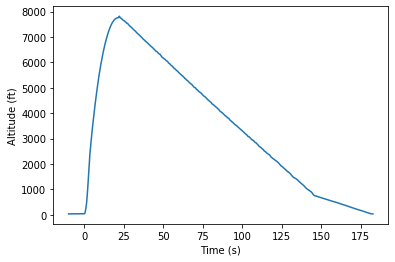

In [15]:
# first, let's plot altitude
times = np.array(data["Time"]).flatten()
alts  = np.array(data["Altitude"]).flatten()
plt.plot(times[times > -10], alts[times > -10])
plt.xlabel("Time (s)")
plt.ylabel("Altitude (ft)")

Yay, that looks about expected - little changes in the slope for drogue and main deployment.

Text(0, 0.5, 'Z-acceleration (Gs)')

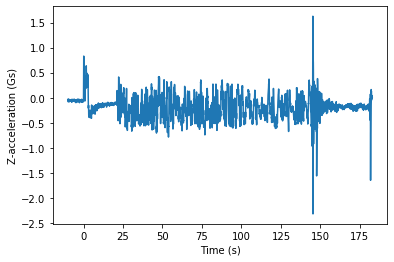

In [16]:
# next, we double-integrate z acceleration. First, let's plot it
z_accs = np.array(data["Zacc"]).flatten() * 9.8
plt.plot(times[times > -10], z_accs[times > -10])
plt.xlabel("Time (s)")
plt.ylabel(r"Z-acceleration $(m/s^2)$")

oof that's noisy. But maybe integrating will help!

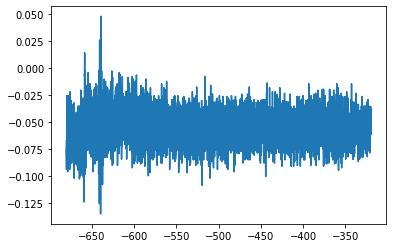

In [17]:
# taking off the zero error: plot of a white-noise period
plt.plot(times[np.abs(times + 500) < 180], z_accs[np.abs(times + 500) < 180])

In [18]:
rms_zero_error = np.sqrt(np.mean(z_accs[np.abs(times + 500) < 200] ** 2))
rms_zero_error

0.05775502088998636

Text(0, 0.5, 'Z position (ft)')

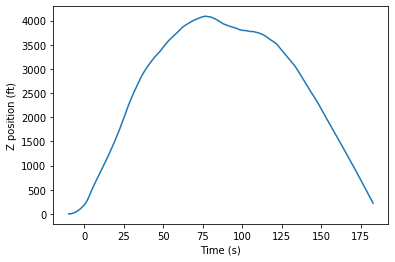

In [19]:
z_vels = integrate.cumtrapz((z_accs + 0.3*rms_zero_error) * (times >= -10) * (32.17/9.8), times) # to ft/s^2
# 0.3 is ad hoc, to zero it out - unclear why it'd just be blowing up otherwise
z_pos  = integrate.cumtrapz(z_vels, times[1:])
plt.plot(times[2:][times[2:] > -10], z_pos[times[2:] > -10])
plt.xlabel("Time (s)")
plt.ylabel("Z position (ft)")

In [127]:
# KF
import importlib
rocketsim = importlib.import_module("rocket-simulation")

import sys
sys.path.append('rocket-simulation/rocket')
from rocket import *

To accurately Kalman filter, we need a good model of the noise from the process and measurements. We can find measurement noise by taking the variance of each sensor at a time when it's not in the air.

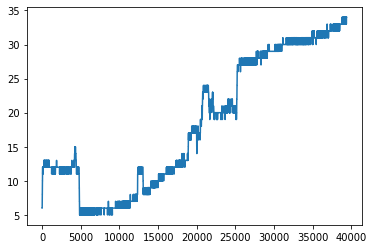

In [22]:
plt.plot(alts[times < -10])

In [96]:
def moving_average(data, window_size=5):
    return np.convolve(data, [1/window_size] * window_size)[window_size//2-1:-window_size//2]

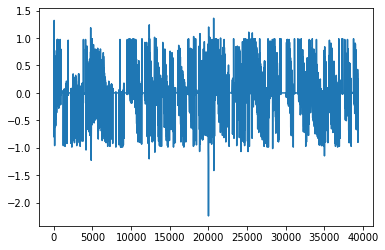

In [101]:
plt.plot(alts[times < -10] - signal.savgol_filter(alts[times < -10], window_length=75, polyorder=1))

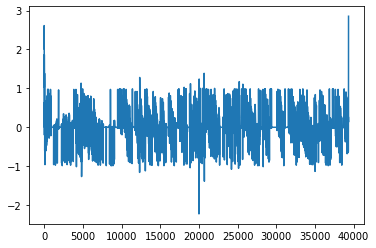

In [104]:
plt.plot((alts[times < -10] - moving_average(alts[times < -10], window_size=75))[:-30])

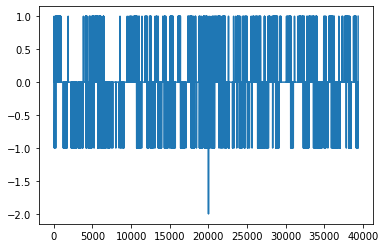

In [112]:
plt.plot(alts[times < -10] - signal.medfilt(alts[times < -10], kernel_size=75))

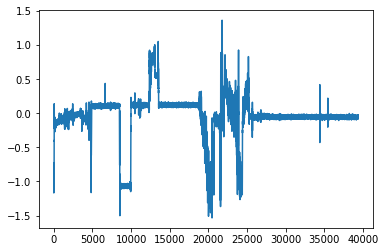

In [105]:
plt.plot(z_accs[times < -10])

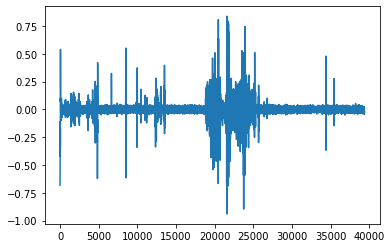

In [111]:
plt.plot((z_accs[times < -10] - moving_average(z_accs[times < -10], window_size=75)))

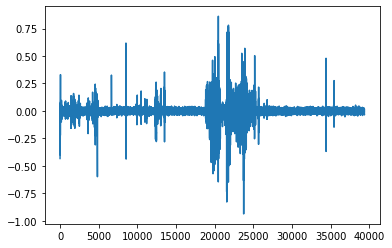

In [113]:
plt.plot(z_accs[times < -10] - signal.medfilt(z_accs[times < -10], kernel_size=75))

In [114]:
altimeter_variation = alts[times < -10] - moving_average(alts[times < -10], window_size=75)
accelerometer_variation = z_accs[times < -10] - moving_average(z_accs[times < -10], window_size=75)
mean_squared = lambda data: np.mean(data ** 2)

In [131]:
# finally, let's estimate drag coefficient, essentially straight from Aled's notebook on this

velocity_interp = scipy.interpolate.interp1d(times, np.concatenate((z_vels, [0])))

motor = Motor(3.674, 1.902, "AeroTech_L1150.txt")

def acceleration_model(t, B1, B2, M, tshift):
    t = t - tshift
    if t <= 0:
        return 9.8
    m = M + motor.mass(t)
    fnet = (motor.mass(t) - 9.8*m - B1*velocity_interp(t) - B2*velocity_interp(t)**2)
    return fnet / m

par0 = [-1, -1, 1.85, 0.15]
par, cov = scipy.optimize.curve_fit(np.vectorize(acceleration_model), 
                                 times[times > -0.15], z_accs[times > -0.15], par0)
print(par)

ValueError: A value in x_new is above the interpolation range.

In [ ]:
def get_airbears():
    mass = 7.219 # kg
    motor = Motor(3.674, 1.902, "AeroTech_L1150.txt")
    drogue = Parachute(0.61, 1.6, "Drogue")
    main = Parachute(1.5, 2.2, "Main")
    altimeter = Sensor(0, mean_squared(altimeter_variation), None)
    accelerometer = Sensor(0, mean_squared(accelerometer_variation), None)
    drag = 
    return Rocket()